# Imports

In [24]:
import os
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import h5py
from pathlib import Path
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

from model_evaluation import *

In [2]:
# Tensorflow Configuration
import multiprocessing

# Get the total number of CPU cores available
total_cores = multiprocessing.cpu_count()

# Calculate 75% of available cores (rounded down)
cores_to_use = int(total_cores * 0.75)

# Ensure at least 1 core is used
cores_to_use = max(1, cores_to_use)

# Set the environment variable
os.environ["LOKY_MAX_CPU_COUNT"] = str(cores_to_use)

print(f"Using {cores_to_use} out of {total_cores} available CPU cores (75%)")

# Add after TensorFlow import
tf.config.threading.set_inter_op_parallelism_threads(cores_to_use // 2)
tf.config.threading.set_intra_op_parallelism_threads(cores_to_use // 2)

Using 12 out of 16 available CPU cores (75%)


# Data Settings

In [20]:
# All bird species available in the HDF5 spectrogram dataset
ALL_BIRD_SPECIES = [
    'amecro',  # American Crow
    'amerob',  # American Robin
    'bewwre',  # Bewick's Wren
    'bkcchi',  # Black-capped Chickadee
    'daejun',  # Dark-eyed Junco
    'houfin',  # House Finch
    'houspa',  # House Sparrow
    'norfli',  # Northern Flicker
    'rewbla',  # Red-winged Blackbird
    'sonspa',  # Song Sparrow
    'spotow',  # Spotted Towhee
    'whcspa',  # White-crowned Sparrow
]

# Selected bird species for binary classification
# Class 1: 'houspa' → House Sparrow
# Class 0: 'sonspa' → Song Sparrow
SELECTED_BIRD_CLASSES = [
    'houspa',  # Class 1
    'sonspa',  # Class 0
]

# Path to the HDF5 file containing bird spectrograms
SPEC_FILE_PATH = Path('../data/bird_spectrograms.hdf5')

# Training hyperparameters
EPOCHS = 50                 # Total number of training epochs
NUM_CV_FOLDS = 3            # K-Fold cross-validation (choose 3, 4, or 5)
BATCH_SIZE = [32]           # Batch size for training
LEARNING_RATE = [0.0001, 0.0005, 0.001]      # Learning rate for the optimizer

# List of evaluation metrics returned by `evaluate()` function
EVALUATION_METRICS = [
    "Weighted Accuracy", "Sensitivity/Recall", "Specificity",
    "Precision_class0", "Precision_class1", "Precision_avg",
    "F1_class0", "F1_class1", "F1_avg", "auc_roc_score",
    "False_Discovery_Rate", "False_Negative_Rate",
    "False_Omission_Rate", "False_Positive_Rate", "Jaccard"
]

# Load Data
We need to transpose the data from (128, 517, sample_size) into (sample_size, 128, 517) because CNNs expect an input of shape (N, C, H, W). 

Here:
- N = number of samples
- C = number of channels (1 for grayscale spectrograms)
- H = height (128)
- W = width (517)

In [4]:
X = []
y = []

label_map = {'houspa': 1, 'sonspa': 0} # 1 for houspa, 0 for sonspa

with h5py.File(SPEC_FILE_PATH, 'r') as f:
    for key in SELECTED_BIRD_CLASSES:
        data = f[key][:]  # shape = (128, 517, N)
        data = np.transpose(data, (2, 0, 1))  # shape = (N, 128, 517)
        X.append(data)
        y.append(np.full(data.shape[0], label_map[key]))  

X = np.concatenate(X, axis=0)  # (N_total, 128, 517)
y = np.concatenate(y)

# Data shape prep for tensorflow
X = np.expand_dims(X, axis=-1)  # (N, 128, 517, 1)
y = np.expand_dims(y, axis=-1)  # (N, 1)

print(X.shape)
print(y.shape)

(893, 128, 517, 1)
(893, 1)


# CNN Model Model Architecture

This convolutional neural network (CNN) performs **binary classification** on spectrogram inputs of shape `(1, 128, 517)`, where:
- `1` is the channel dimension (grayscale),
- `128` is the number of frequency bins (height),
- `517` is the number of time steps (width).

---

### General Steps for CNN
According to a very long discussion on the order of layers, BN, DropOut, and Pooling on [stackoverflow](https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout) <br>
Generally, this laying is the consensus. <br>

Conv → BatchNorm → ReLU → Dropout → MaxPool

# CNN Model #1

In [ ]:
def build_bird_binary_cnn_v1(input_shape=(128, 517, 1), dropout_rate=0.2, learning_rate=0.0001):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
    
    return model

def build_bird_binary_cnn_v2(input_shape=(128, 517, 1), dropout_rate=0.2, learning_rate=0.0001):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(128, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
    
    return model

# Graph Plotting

In [18]:
def build_plot_training_history(history, path, tag):
    """
    Plots training and validation accuracy and loss from two training histories.

    Args:
        history: First training history object.
        history2: Second training history object.
    """
    # Extract values from history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{path}/{tag}_acc.png')
    plt.show()
    plt.close()

    # Plot Loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{path}/{tag}_loss.png')
    plt.show()
    plt.close()

# Model Training and Evaluation Loop

For CNNs, these four essential steps are important. <br>
I have explained more about backpropagation in this [Medium article](https://medium.com/data-science-collective/why-backpropagation-is-so-important-for-models-in-machine-learning-4736591b24b3)

- Forward pass: Feed input through the network to make a prediction.
- Loss calculation: It compares those predictions to the actual labels and computes the loss.
- Backpropagation: Use the chain rule to find how much each weight influenced the loss.
- Weight update: Apply the gradients using an optimizer like Adam.
---

## Reasoning behind of KFold Cross Validation
Since the dataset is relatively small, it may be best to go with just a KFold Cross Validation rather than doing a train-test split + cross-validation. <br>

That is the reason why I went with K-fold cross validation.

---

# 4 Layer Model Run for params
- 3 FOLD (stratified)
- Batch Size = 32
- Dropout = 0.2
- Learning Rate = [0.001, 0.005, 0.0001]
- 50 EPOCHS with early stopping.

In [ ]:
# K-Fold CV
kfold = StratifiedKFold(n_splits=NUM_CV_FOLDS, shuffle=True, random_state=42)

for batch_size in BATCH_SIZE:
    for learning_rate in LEARNING_RATE:
        version_key_prefix = f"binary_4layer_{batch_size}_{learning_rate}_{EPOCHS}"
        fold_results = []
        metrics = pd.DataFrame(columns=EVALUATION_METRICS)

        for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
            print(f"\nFold {fold + 1} | Train size: {len(train_idx)}, Test size: {len(test_idx)}")

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            print(X_train.shape[1:])
            # Initialize model
            model = build_bird_binary_cnn_v2(input_shape=X_train.shape[1:], dropout_rate=0.2, learning_rate=learning_rate)

            # Callbacks
            early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

            # Train
            history = model.fit(
                X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=EPOCHS,
                batch_size=batch_size,
                callbacks=[early_stopping, reduce_lr],
                verbose=1
            )

            fold_tag = f"{version_key_prefix}_fold_{fold + 1}"
            result_path = f"../output/binary_results"

            # Optional: Training history visualization
            build_plot_training_history(history, result_path, fold_tag)

            # Evaluate
            evaluator = BinaryEvaluation(model)
            results, confusion_matrix = evaluator.model_test(X_test, y_test)
            print(confusion_matrix)

            # Save current fold's result
            metrics.loc[fold_tag] = list(results)

            # Cleanup
            K.clear_session()
            del model
            gc.collect()

        # Save all 3 folds' metrics into a single CSV file
        result_subset = metrics.loc[[f"{version_key_prefix}_fold_{i+1}" for i in range(NUM_CV_FOLDS)]]
        output_path = f"{result_path}/4layer_{version_key_prefix}_results.csv"
        result_subset.to_csv(output_path, index_label="Fold")

# 4 Layer Model Best Result
- Batch Size = 32
- Dropout = 0.2
- Learning Rate = 0.005, 0.0001
- 50 EPOCHS with early stopping.

(128, 517, 1)
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5473 - loss: 0.8575 - val_accuracy: 0.3073 - val_loss: 1.1084 - learning_rate: 5.0000e-04
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7020 - loss: 0.5941 - val_accuracy: 0.6760 - val_loss: 0.5794 - learning_rate: 5.0000e-04
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.7936 - loss: 0.4802 - val_accuracy: 0.6592 - val_loss: 0.6079 - learning_rate: 5.0000e-04
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.7573 - loss: 0.4935 - val_accuracy: 0.5140 - val_loss: 0.6926 - learning_rate: 5.0000e-04
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8023 - loss: 0.4363 - val_accuracy: 0.6313 - val_loss: 0.6234 - learning_rate: 5.0000e-04
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8015 - loss: 0.4098 - val_accuracy: 0.7095 - val_loss: 0.5484 - learning_rate: 5.0000e-04
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 

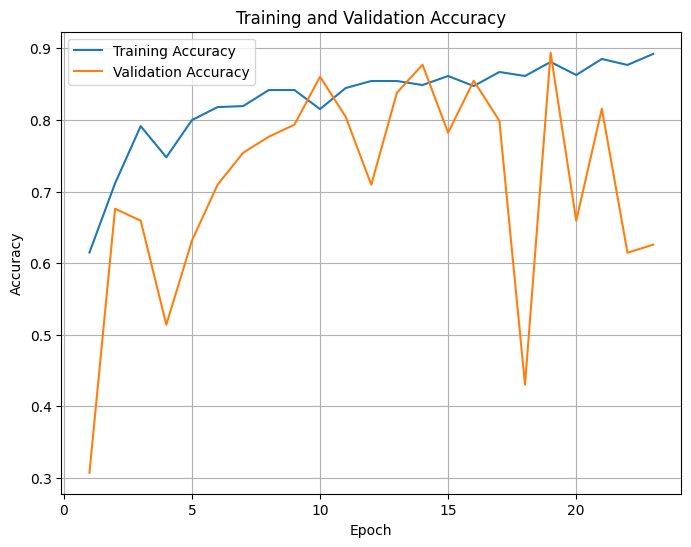

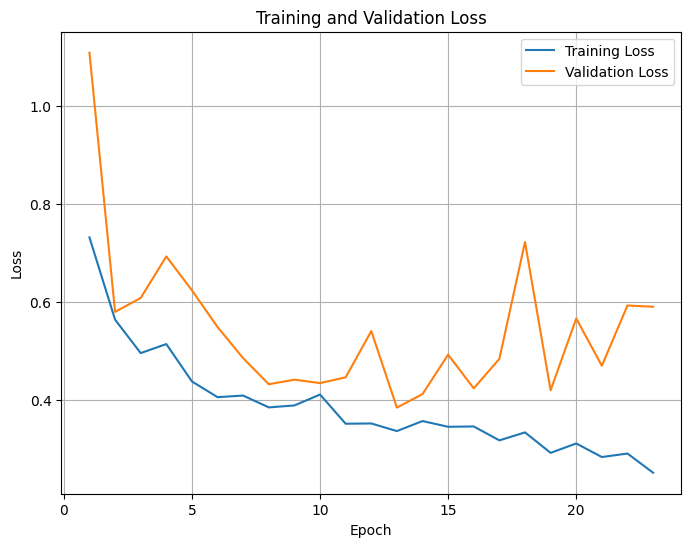

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step
[[ 32  23]
 [  6 118]]
                            Weighted Accuracy  Sensitivity/Recall  \
4_Layer_best_model_results           0.766716            0.581818   

                            Specificity  Precision_class0  Precision_class1  \
4_Layer_best_model_results     0.951613          0.842105          0.836879   

                            Precision_avg  F1_class0  F1_class1    F1_avg  \
4_Layer_best_model_results       0.839492   0.688172   0.890566  0.789369   

                            auc_roc_score  False_Discovery_Rate  \
4_Layer_best_model_results       0.766716              0.157895   

                            False_Negative_Rate  False_Omission_Rate  \
4_Layer_best_model_results             0.418182             0.163121   

                            False_Positive_Rate  Jaccard  
4_Layer_best_model_results             0.048387  0.52459  


In [ ]:
# Run 4 layer model with best result
metrics = pd.DataFrame(columns=EVALUATION_METRICS)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True
)

print(X_train.shape[1:])
# Initialize model
model = build_bird_binary_cnn_v2(input_shape=X_train.shape[1:], dropout_rate=0.2, learning_rate=0.0005)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Visualize training history (optional)
result_path = "../output/binary_results"
run_tag = f"4_Layer_best_model_results"
build_plot_training_history(history, result_path, run_tag)

# Evaluate
evaluator = BinaryEvaluation(model)
results, confusion_matrix = evaluator.model_test(X_test, y_test)
print(confusion_matrix)

# Save results
metrics = pd.DataFrame(columns=EVALUATION_METRICS)
metrics.loc[run_tag] = list(results)

# Cleanup
K.clear_session()
del model
gc.collect()

display(metrics)

In [28]:
display(metrics)

,Weighted Accuracy,Sensitivity/Recall,Specificity,Precision_class0,Precision_class1,Precision_avg,F1_class0,F1_class1,F1_avg,auc_roc_score,False_Discovery_Rate,False_Negative_Rate,False_Omission_Rate,False_Positive_Rate,Jaccard
4_Layer_best_model_results,0.766716,0.581818,0.951613,0.842105,0.836879,0.839492,0.688172,0.890566,0.789369,0.766716,0.157895,0.418182,0.163121,0.048387,0.52459


# 2 Layer Model Run for params
- 3 FOLD (stratified)
- Batch Size = 32
- Dropout = 0.2
- Learning Rate = [0.001, 0.005, 0.0001]
- 50 EPOCHS with early stopping.

In [ ]:
# K-Fold CV
kfold = StratifiedKFold(n_splits=NUM_CV_FOLDS, shuffle=True, random_state=42)
metrics = pd.DataFrame(columns=EVALUATION_METRICS)

for batch_size in BATCH_SIZE:
    for learning_rate in LEARNING_RATE:
        version_key_prefix = f"binary_{batch_size}_{learning_rate}_{EPOCHS}"
        fold_results = []

        for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
            print(f"\nFold {fold + 1} | Train size: {len(train_idx)}, Test size: {len(test_idx)}")

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            print(X_train.shape[1:])
            # Initialize model
            model = build_bird_binary_cnn_v1(input_shape=X_train.shape[1:], dropout_rate=0.2, learning_rate=learning_rate)

            # Callbacks
            early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

            # Train
            history = model.fit(
                X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=EPOCHS,
                batch_size=batch_size,
                callbacks=[early_stopping, reduce_lr],
                verbose=1
            )

            # Optional: Training history visualization
            build_plot_training_history(history)

            # Evaluate
            evaluator = BinaryEvaluation(model)
            results, confusion_matrix = evaluator.model_test(X_test, y_test)
            print(confusion_matrix)

            # Save current fold's result
            fold_tag = f"{version_key_prefix}_fold_{fold + 1}"
            metrics.loc[fold_tag] = list(results)

            # Cleanup
            K.clear_session()
            del model
            gc.collect()

        # Save all 3 folds' metrics into a single CSV file
        result_subset = metrics.loc[[f"{version_key_prefix}_fold_{i+1}" for i in range(NUM_CV_FOLDS)]]
        output_path = f"../output/binary_results/{version_key_prefix}_results.csv"
        result_subset.to_csv(output_path, index_label="Fold")

# 2 Layer Model Best
- Batch Size = 32
- Dropout = 0.2
- Learning Rate = 0.0001
- 50 EPOCHS with early stopping.

(128, 517, 1)
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5568 - loss: 0.7285 - val_accuracy: 0.2849 - val_loss: 2.3856 - learning_rate: 1.0000e-04
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6372 - loss: 0.6544 - val_accuracy: 0.2849 - val_loss: 1.4624 - learning_rate: 1.0000e-04
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.6446 - loss: 0.6670 - val_accuracy: 0.2849 - val_loss: 1.0477 - learning_rate: 1.0000e-04
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6415 - loss: 0.6540 - val_accuracy: 0.3017 - val_loss: 0.7876 - learning_rate: 1.0000e-04
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6525 - loss: 0.6453 - val_accuracy: 0.3352 - val_loss: 0.7386 - learning_rate: 1.0000e-04
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6838 - loss: 0.6530 - val_accuracy: 0.6034 - val_loss: 0.6880 - learning_rate: 1.0000e-04
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 

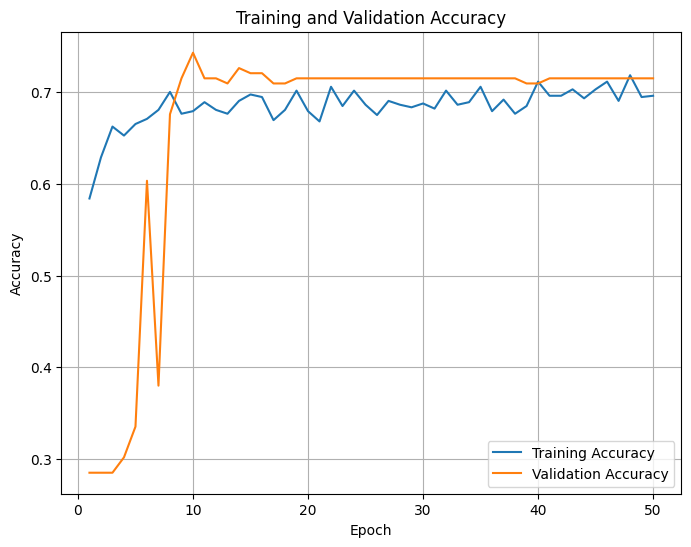

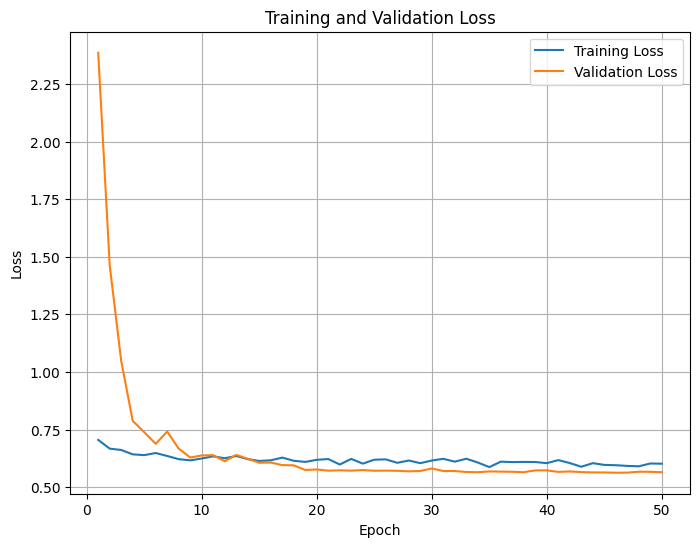

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step
[[  0  51]
 [  0 128]]


,Weighted Accuracy,Sensitivity/Recall,Specificity,Precision_class0,Precision_class1,Precision_avg,F1_class0,F1_class1,F1_avg,auc_roc_score,False_Discovery_Rate,False_Negative_Rate,False_Omission_Rate,False_Positive_Rate,Jaccard
2_layer_best_model_results,0.5,0.0,1.0,0.0,0.715084,0.357542,0.0,0.833876,0.416938,0.5,0.0,1.0,0.284916,0.0,0.0


In [30]:
# Run 2 layer model with best result
metrics = pd.DataFrame(columns=EVALUATION_METRICS)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True
)

print(X_train.shape[1:])
# Initialize model
model = build_bird_binary_cnn_v1(input_shape=X_train.shape[1:], dropout_rate=0.2, learning_rate=0.0001)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Visualize training history (optional)
result_path = "../output/binary_results"
run_tag = f"2_layer_best_model_results"
build_plot_training_history(history, result_path, run_tag)

# Evaluate
evaluator = BinaryEvaluation(model)
results, confusion_matrix = evaluator.model_test(X_test, y_test)
print(confusion_matrix)

# Save results
metrics = pd.DataFrame(columns=EVALUATION_METRICS)
metrics.loc[run_tag] = list(results)

# Cleanup
K.clear_session()
del model
gc.collect()

display(metrics)